In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ShallowNetwork

# Test for RMSE

Let's test if the written shallow network class works for a simple case of fitting it to the cosine function with the RMSE loss function.

In [2]:
X = np.arange(0, 2 * np.pi, 0.03)
X = X.reshape((X.shape[0], 1, 1))
Y = np.sin(X)

## Definining loss functions

In [3]:
def loss_function_single_point(self, point, ground_truth):
        N = self.forward_pass(point, 0)
        loss = np.sqrt(((N - ground_truth) ** 2).sum())
        return loss

In [4]:
def loss_function_all(self, samples, labels):
        loss = 0
        n_inv = len(samples) ** -1
        for i in range(samples.shape[0]):
            loss += self.loss_function_single_point(self, samples[i], labels[i]) ** 2
        loss *= n_inv
        loss = np.sqrt(loss)
        return loss

## Defining the update rules

In [5]:
def bias_change_point(self, point, label):
  db = np.zeros((self.hidden_dim, 1)).astype(dtype="float64")
  change = self.forward_pass(point, 0) - label
  loss = self.loss_function_single_point(self, point, label)
  db_N = self.network_derivative_bias(point, 0)
  for m in range(self.hidden_dim):
    for j in range(self.visible_dim):
      db[m] += change[j] * db_N[j, 0, m]
  db /= loss
  return db

In [6]:
def hidden_weights_change_point(self, point, label):
  dH = np.zeros((self.hidden_dim, self.input_dim)).astype(dtype="float64")
  change = self.forward_pass(point, 0) - label
  loss = self.loss_function_single_point(self, point, label)
  dH_N = self.network_derivative_hidden_weights(point, 0)
  for m in range(self.hidden_dim):
    for p in range(self.input_dim):
      for j in range(self.visible_dim):
        dH[m, p] += change[j] * dH_N[j, 0, m, p]
  dH /= loss
  return dH

In [7]:
def visible_weights_change_point(self, point, label):
  dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
  change = self.forward_pass(point, 0) - label
  loss = self.loss_function_single_point(self, point, label)
  dV_N = self.network_derivative_visible_weights(point, 0)
  for m in range(self.visible_dim):
    for p in range(self.hidden_dim):
      for j in range(self.visible_dim):
        dV[m, p] += change[j] * dV_N[j, 0, m, p]
  dV /= loss
  return dV

## Defining the netowork for the task

In [8]:
network = ShallowNetwork.ShallowNetwork(loss_function=loss_function_all,
                                        loss_function_single_point=loss_function_single_point,
                                       bias_change=bias_change_point,
                                       hidden_weights_change=hidden_weights_change_point,
                                       visible_weights_change=visible_weights_change_point,
                                       hidden_dim=50, unsupervised=False, momentum=0, learning_rate=0.1)

In [9]:
network.train(samples=X, labels=Y, epochs=10)

Epoch: 1 Loss function: 1.455663928971233
Epoch: 2 Loss function: 0.5188670065789509
Epoch: 3 Loss function: 0.48341567094040266
Epoch: 4 Loss function: 0.3369823755050468
Epoch: 5 Loss function: 0.4616042618537419
Epoch: 6 Loss function: 0.7983873995643652
Epoch: 7 Loss function: 0.271004329583058
Epoch: 8 Loss function: 0.28322646475978314
Epoch: 9 Loss function: 0.38866982289359964
Epoch: 10 Loss function: 0.36118477245241903


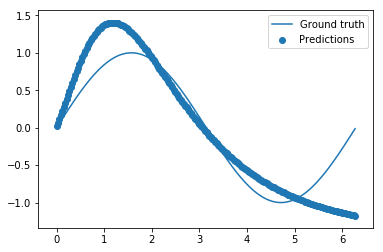

In [10]:
Y2 = np.array([network.forward_pass(X[i], 0) for i in range(X.shape[0])])
Xp = X.reshape((X.shape[0],))
Yp = Y.reshape((Y.shape[0],))
plt.plot(Xp, Yp, label='Ground truth')
plt.scatter(Xp, Y2, label='Predictions')
plt.legend()
plt.show() 

## Trial Solution class

In [11]:
class Trial_Solution:
  def __init__(self, loss_function, loss_function_single_point,
               bias_change, hidden_weights_change, visible_weights_change,
               boundary_condition_value_function, boundary_vanishing_function,
               input_dim=1, hidden_dim=1, output_dim=1, momentum=0, learning_rate=0.1):
    # Dimensions of the Shallow Network
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    
    # Defining all of the three parts of the trial solution f(X)=A(X)+B(X)N(X)
    # A(X) is a function fullfiling the boundary or initial conditions
    self.boundary_condition_value_function = boundary_condition_value_function
    # B(X) is a function vanishing on the boundary or in the initial moment
    self.boundary_vanishing_function = boundary_vanishing_function
    # N(X) is the Shallow Network
    self.network = ShallowNetwork.ShallowNetwork(
      input_dim=self.input_dim, hidden_dim=self.hidden_dim, visible_dim=self.output_dim,
      momentum=momentum, learning_rate=learning_rate, loss_function=loss_function,
      loss_function_single_point=loss_function_single_point, bias_change=bias_change,
      hidden_weights_change=hidden_weights_change, visible_weights_change=visible_weights_change,
      unsupervised=True)

  def predict(self, X):
    return self.boundary_condition_value_function(X) + self.boundary_vanishing_function(X) * self.network.forward_pass(X, 0)
    
  def train(self, samples, epochs):
    self.network.train(samples=samples, epochs=epochs, labels=None)

## Example 1

$\frac{d}{dx}\Psi+(x+\frac{1+3x^2}{1+x+x^3})\Psi=x^3+2x+x^2\frac{1+3x^2}{1+x+x^3}$

With boundary initial condition $\Psi(0)=1$ and domain $x\in[0,1]$

In [37]:
Xe1 = np.arange(0,1,0.05) + 1e-6
Xe1 = Xe1.reshape((Xe1.shape[0],1,1))

In [14]:
def example1_initial_value(point):
  return 1

In [15]:
def example1_boundary_vanishing(point):
  return point

In [16]:
def example1_loss_function_single_point(self, point, non_squared=False, *kwargs):
  N = self.forward_pass(point, 0)
  dN = self.forward_pass(point, 1)
  loss = (
      point * dN + N + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * (1 + point * N) 
      - point ** 3 - 2 * point - (1 + 3 * point ** 2)/(1 + point + point ** 3)
    )
  if not non_squared:
    loss = loss ** 2
  return loss[0,0]

In [17]:
def example1_loss_function(self, samples, *kwargs):
  loss = 0
  for i in range(samples.shape[0]):
    loss += self.loss_function_single_point(self, samples[i])
  return loss/samples.shape[0]

In [18]:
def example1_bias_change(self, point, label, *kwargs):
  db = np.zeros((self.hidden_dim, 1)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  db_N = self.network_derivative_bias(point, 0)
  db_DN = self.network_derivative_bias(point, 1)
  point = point.reshape((1,))
  for m in range(self.hidden_dim):
    db[m] += 2 * loss_sqrt * (
      point * db_DN[0, 0, m] + db_N[0, 0, m] + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * point * db_N[0, 0, m])
  return db

In [19]:
def example1_hidden_weights_change(self, point, *kwargs):
  dH = np.zeros((self.hidden_dim, self.input_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dH_N = self.network_derivative_hidden_weights(point, 0)
  dH_DN = self.network_derivative_hidden_weights(point, 1)
  for m in range(self.hidden_dim):
    for p in range(self.input_dim):
      dH[m, p] += 2 * loss_sqrt * (
        point * dH_DN[0, 0, m, p] + dH_N[0, 0, m, p] + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * point * dH_N[0, 0, m, p])
  return dH

In [20]:
def example1_visible_weights_change(self, point, *kwargs):
  dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dV_N = self.network_derivative_visible_weights(point, 0)
  dV_DN = self.network_derivative_visible_weights(point, 1)
  for m in range(self.visible_dim):
    for p in range(self.hidden_dim):
      dV[m, p] += 2 * loss_sqrt * (
        point * dV_DN[0, 0, m, p] + dV_N[0, 0, m, p] + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * point * dV_N[0, 0, m, p])
  return dV

In [38]:
example1_trial_solution = Trial_Solution(loss_function=example1_loss_function,
                                        loss_function_single_point=example1_loss_function_single_point,
                                        bias_change=example1_bias_change,
                                        hidden_weights_change=example1_hidden_weights_change,
                                        visible_weights_change=example1_visible_weights_change,
                                        boundary_condition_value_function=example1_initial_value,
                                        boundary_vanishing_function=example1_boundary_vanishing,
                                        input_dim=1, hidden_dim=20, output_dim=1, learning_rate=1e-1)

In [39]:
example1_trial_solution.train(Xe1, 2000)

Epoch: 1 Loss function: 1.7956014144408523
Epoch: 2 Loss function: 0.2656287614299502
Epoch: 3 Loss function: 0.15454273288734274
Epoch: 4 Loss function: 0.022614599192831923
Epoch: 5 Loss function: 0.3130249075796501
Epoch: 6 Loss function: 0.004747231536683952
Epoch: 7 Loss function: 0.0021478381523790434
Epoch: 8 Loss function: 0.9343235290307801
Epoch: 9 Loss function: 0.005560381089684066
Epoch: 10 Loss function: 0.0115122555822143
Epoch: 11 Loss function: 0.02967470153605687
Epoch: 12 Loss function: 0.004710541484201478
Epoch: 13 Loss function: 0.00220203703492969
Epoch: 14 Loss function: 0.0035823815032651
Epoch: 15 Loss function: 0.01738132111793462
Epoch: 16 Loss function: 0.008768805643030711
Epoch: 17 Loss function: 0.06022740550081682
Epoch: 18 Loss function: 0.001715778958443064
Epoch: 19 Loss function: 0.009452900881639444
Epoch: 20 Loss function: 0.008382617001792316
Epoch: 21 Loss function: 0.005882409880404358
Epoch: 22 Loss function: 0.01222278607244017
Epoch: 23 Loss

Epoch: 181 Loss function: 0.0025663093778124976
Epoch: 182 Loss function: 0.002015873410204124
Epoch: 183 Loss function: 0.0022607141714703557
Epoch: 184 Loss function: 0.0018675851886842908
Epoch: 185 Loss function: 0.00188812707668017
Epoch: 186 Loss function: 0.003054585926275958
Epoch: 187 Loss function: 0.0027659898097169796
Epoch: 188 Loss function: 0.002143332759797555
Epoch: 189 Loss function: 0.0018810666492918946
Epoch: 190 Loss function: 0.0019762943211301437
Epoch: 191 Loss function: 0.002331649396763428
Epoch: 192 Loss function: 0.0023774716279338385
Epoch: 193 Loss function: 0.004068023613195947
Epoch: 194 Loss function: 0.00214938687244047
Epoch: 195 Loss function: 0.0018355385517631706
Epoch: 196 Loss function: 0.0019854403602944117
Epoch: 197 Loss function: 0.0020921349442758414
Epoch: 198 Loss function: 0.001833102517072765
Epoch: 199 Loss function: 0.0022096582704091883
Epoch: 200 Loss function: 0.002385278487509492
Epoch: 201 Loss function: 0.0034781948894683544
Epo

Epoch: 354 Loss function: 0.0022851172081554093
Epoch: 355 Loss function: 0.0018970129476463665
Epoch: 356 Loss function: 0.0018952974191235657
Epoch: 357 Loss function: 0.001917293701460437
Epoch: 358 Loss function: 0.0018232219381599693
Epoch: 359 Loss function: 0.0023518353890956177
Epoch: 360 Loss function: 0.0019147609363787555
Epoch: 361 Loss function: 0.0018795228508786323
Epoch: 362 Loss function: 0.002291258324279237
Epoch: 363 Loss function: 0.001786779251431645
Epoch: 364 Loss function: 0.002647937269203425
Epoch: 365 Loss function: 0.0017855658763498085
Epoch: 366 Loss function: 0.0032651454722483183
Epoch: 367 Loss function: 0.00198477103461643
Epoch: 368 Loss function: 0.001858220955607832
Epoch: 369 Loss function: 0.0017875607107538673
Epoch: 370 Loss function: 0.001967452090662388
Epoch: 371 Loss function: 0.0018113910565512599
Epoch: 372 Loss function: 0.0019207565318551056
Epoch: 373 Loss function: 0.0019002616373632118
Epoch: 374 Loss function: 0.0018263881796494817


Epoch: 529 Loss function: 0.0017815525385530238
Epoch: 530 Loss function: 0.0023643152903329292
Epoch: 531 Loss function: 0.0019438105357448333
Epoch: 532 Loss function: 0.002213478210824309
Epoch: 533 Loss function: 0.001928103986393305
Epoch: 534 Loss function: 0.00176182998502702
Epoch: 535 Loss function: 0.0017522123392459924
Epoch: 536 Loss function: 0.0017734022042027188
Epoch: 537 Loss function: 0.00275757349443978
Epoch: 538 Loss function: 0.0020573920215584797
Epoch: 539 Loss function: 0.0018887363657787508
Epoch: 540 Loss function: 0.0023603047934289273
Epoch: 541 Loss function: 0.0017504728679792758
Epoch: 542 Loss function: 0.001963978673212686
Epoch: 543 Loss function: 0.001762412501494503
Epoch: 544 Loss function: 0.002080115355849688
Epoch: 545 Loss function: 0.0019230093212505035
Epoch: 546 Loss function: 0.002844746932750993
Epoch: 547 Loss function: 0.0018488265085706752
Epoch: 548 Loss function: 0.001774603293273981
Epoch: 549 Loss function: 0.001754209630737275
Epoc

Epoch: 701 Loss function: 0.0017233542519891943
Epoch: 702 Loss function: 0.00187606664143284
Epoch: 703 Loss function: 0.0018033913391382998
Epoch: 704 Loss function: 0.0017372866477687796
Epoch: 705 Loss function: 0.0018048641793922799
Epoch: 706 Loss function: 0.0018907544372252481
Epoch: 707 Loss function: 0.0017149312542821178
Epoch: 708 Loss function: 0.003508961392371875
Epoch: 709 Loss function: 0.0021025206592889924
Epoch: 710 Loss function: 0.0024650398706736387
Epoch: 711 Loss function: 0.0018494265530658916
Epoch: 712 Loss function: 0.0022769429975020433
Epoch: 713 Loss function: 0.0017880050101961452
Epoch: 714 Loss function: 0.0018827570249575708
Epoch: 715 Loss function: 0.002164890550215918
Epoch: 716 Loss function: 0.0021027783082058628
Epoch: 717 Loss function: 0.002055037209317079
Epoch: 718 Loss function: 0.0017164007624771507
Epoch: 719 Loss function: 0.001796118050683074
Epoch: 720 Loss function: 0.0017223473569465378
Epoch: 721 Loss function: 0.003656022845772606

Epoch: 878 Loss function: 0.001998668012633498
Epoch: 879 Loss function: 0.0036622576135015433
Epoch: 880 Loss function: 0.0017772411307912562
Epoch: 881 Loss function: 0.002106189954502134
Epoch: 882 Loss function: 0.0017193629011211197
Epoch: 883 Loss function: 0.0017201070432692467
Epoch: 884 Loss function: 0.0016913948346406749
Epoch: 885 Loss function: 0.0023145359696400735
Epoch: 886 Loss function: 0.003134704559544894
Epoch: 887 Loss function: 0.0021101056225603224
Epoch: 888 Loss function: 0.001823844975514028
Epoch: 889 Loss function: 0.0017985748917509138
Epoch: 890 Loss function: 0.002619421358614166
Epoch: 891 Loss function: 0.0018560886971005631
Epoch: 892 Loss function: 0.002307674284696861
Epoch: 893 Loss function: 0.001707266182707871
Epoch: 894 Loss function: 0.003298779267526101
Epoch: 895 Loss function: 0.0017039511691799378
Epoch: 896 Loss function: 0.0017182789924271326
Epoch: 897 Loss function: 0.0018690417142217107
Epoch: 898 Loss function: 0.002842506278615227
E

Epoch: 1050 Loss function: 0.0016642878945615648
Epoch: 1051 Loss function: 0.001801652593099916
Epoch: 1052 Loss function: 0.0023849098857726893
Epoch: 1053 Loss function: 0.00301213263907638
Epoch: 1054 Loss function: 0.0019477894382255508
Epoch: 1055 Loss function: 0.003269481358366222
Epoch: 1056 Loss function: 0.0019854776027612014
Epoch: 1057 Loss function: 0.0019181567297158891
Epoch: 1058 Loss function: 0.0018657406121284459
Epoch: 1059 Loss function: 0.0016547127146821928
Epoch: 1060 Loss function: 0.0016561033162408735
Epoch: 1061 Loss function: 0.001868978336747209
Epoch: 1062 Loss function: 0.00198410658062476
Epoch: 1063 Loss function: 0.0016621815686696563
Epoch: 1064 Loss function: 0.0018571872563805415
Epoch: 1065 Loss function: 0.0017980834330115435
Epoch: 1066 Loss function: 0.0016662344617224204
Epoch: 1067 Loss function: 0.0018779963056762099
Epoch: 1068 Loss function: 0.0027078301584385093
Epoch: 1069 Loss function: 0.0019356212173055423
Epoch: 1070 Loss function: 

Epoch: 1219 Loss function: 0.002014946358568209
Epoch: 1220 Loss function: 0.0018048204812779888
Epoch: 1221 Loss function: 0.001644939636303663
Epoch: 1222 Loss function: 0.0016302265096350057
Epoch: 1223 Loss function: 0.002053878574858732
Epoch: 1224 Loss function: 0.0017422096724133882
Epoch: 1225 Loss function: 0.0016749313746978287
Epoch: 1226 Loss function: 0.0017055714530361844
Epoch: 1227 Loss function: 0.0016311939405053246
Epoch: 1228 Loss function: 0.0018301176580822962
Epoch: 1229 Loss function: 0.001650132419134673
Epoch: 1230 Loss function: 0.003235241655652272
Epoch: 1231 Loss function: 0.002215222202682935
Epoch: 1232 Loss function: 0.001654759904102685
Epoch: 1233 Loss function: 0.0016352398139574443
Epoch: 1234 Loss function: 0.001761896371150064
Epoch: 1235 Loss function: 0.001636708790649187
Epoch: 1236 Loss function: 0.0017373973210073877
Epoch: 1237 Loss function: 0.0016331732123847757
Epoch: 1238 Loss function: 0.0019576018846755435
Epoch: 1239 Loss function: 0.

Epoch: 1390 Loss function: 0.001685672242817184
Epoch: 1391 Loss function: 0.001720306092703381
Epoch: 1392 Loss function: 0.0019047845153394006
Epoch: 1393 Loss function: 0.0020228154004589384
Epoch: 1394 Loss function: 0.0016270598287764144
Epoch: 1395 Loss function: 0.0016787197883323848
Epoch: 1396 Loss function: 0.0016419831943999257
Epoch: 1397 Loss function: 0.001814104827334437
Epoch: 1398 Loss function: 0.0016897662003018447
Epoch: 1399 Loss function: 0.0016138759785979933
Epoch: 1400 Loss function: 0.0016382095867397486
Epoch: 1401 Loss function: 0.0016689554719722672
Epoch: 1402 Loss function: 0.002094228323085756
Epoch: 1403 Loss function: 0.001614877390384473
Epoch: 1404 Loss function: 0.0018673691795364343
Epoch: 1405 Loss function: 0.0027950802550953846
Epoch: 1406 Loss function: 0.0016429058071950199
Epoch: 1407 Loss function: 0.0017745106508746263
Epoch: 1408 Loss function: 0.0019901526137385732
Epoch: 1409 Loss function: 0.001894088462554073
Epoch: 1410 Loss function:

Epoch: 1560 Loss function: 0.0016745667971150204
Epoch: 1561 Loss function: 0.0024034849113388672
Epoch: 1562 Loss function: 0.00235335921432464
Epoch: 1563 Loss function: 0.001655190706291268
Epoch: 1564 Loss function: 0.0015945419254019065
Epoch: 1565 Loss function: 0.0016065202442822428
Epoch: 1566 Loss function: 0.0017699971694645777
Epoch: 1567 Loss function: 0.0016117991515118856
Epoch: 1568 Loss function: 0.0016294465650383977
Epoch: 1569 Loss function: 0.0017736758495739621
Epoch: 1570 Loss function: 0.0017342121087724875
Epoch: 1571 Loss function: 0.001659641027813524
Epoch: 1572 Loss function: 0.0015971491238518213
Epoch: 1573 Loss function: 0.0015965541424558377
Epoch: 1574 Loss function: 0.001640140783650218
Epoch: 1575 Loss function: 0.0017801637199287255
Epoch: 1576 Loss function: 0.0016453794097718078
Epoch: 1577 Loss function: 0.0019151388264103419
Epoch: 1578 Loss function: 0.0016071345682715002
Epoch: 1579 Loss function: 0.001727837459415181
Epoch: 1580 Loss function:

Epoch: 1733 Loss function: 0.0017034764060755718
Epoch: 1734 Loss function: 0.0023908746710043774
Epoch: 1735 Loss function: 0.0020833041336630782
Epoch: 1736 Loss function: 0.00254155318941287
Epoch: 1737 Loss function: 0.0018623317878169884
Epoch: 1738 Loss function: 0.0016279285050039781
Epoch: 1739 Loss function: 0.001914335420552412
Epoch: 1740 Loss function: 0.0016085835647745162
Epoch: 1741 Loss function: 0.0017185880200080328
Epoch: 1742 Loss function: 0.0016549546632759035
Epoch: 1743 Loss function: 0.0016174629313924621
Epoch: 1744 Loss function: 0.0025567643207530344
Epoch: 1745 Loss function: 0.0015707877212171703
Epoch: 1746 Loss function: 0.001577459635961135
Epoch: 1747 Loss function: 0.0015736296762793548
Epoch: 1748 Loss function: 0.001998166024470394
Epoch: 1749 Loss function: 0.001891384510230834
Epoch: 1750 Loss function: 0.001823205026253137
Epoch: 1751 Loss function: 0.0015951100072515907
Epoch: 1752 Loss function: 0.0015706404046557719
Epoch: 1753 Loss function: 

Epoch: 1909 Loss function: 0.0016489660441029019
Epoch: 1910 Loss function: 0.0015536673011833134
Epoch: 1911 Loss function: 0.0015612729003826984
Epoch: 1912 Loss function: 0.0018043711763649547
Epoch: 1913 Loss function: 0.0015979299353440861
Epoch: 1914 Loss function: 0.0015584987299253074
Epoch: 1915 Loss function: 0.0017345386694676875
Epoch: 1916 Loss function: 0.0016453552389905936
Epoch: 1917 Loss function: 0.0025511413218381887
Epoch: 1918 Loss function: 0.0017729539267277053
Epoch: 1919 Loss function: 0.0015924791677581634
Epoch: 1920 Loss function: 0.002776416839614192
Epoch: 1921 Loss function: 0.0024486531389352893
Epoch: 1922 Loss function: 0.001723989704734434
Epoch: 1923 Loss function: 0.001554080110205715
Epoch: 1924 Loss function: 0.0019579487415582516
Epoch: 1925 Loss function: 0.0015643389101997085
Epoch: 1926 Loss function: 0.0016489597342286301
Epoch: 1927 Loss function: 0.0016419290064924833
Epoch: 1928 Loss function: 0.0020313802088854334
Epoch: 1929 Loss functi

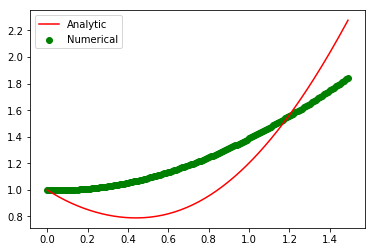

In [47]:
Xe1plot = np.arange(0,1.5, 0.01)
Xe1plot = Xe1plot.reshape((Xe1plot.shape[0], 1, 1))
Ye1 = np.array([example1_trial_solution.predict(Xe1plot[i]) for i in range(Xe1plot.shape[0])]).reshape((Xe1plot.shape[0],))
Xe1plot = Xe1plot.reshape((Xe1plot.shape[0],))
Ye12 = np.array([np.exp(-0.5*Xe1plot[i]**2)/(1+Xe1plot[i]+Xe1plot[i]**3) + Xe1plot[i]**2 for i in range(Xe1plot.shape[0])])
plt.scatter(Xe1plot, Ye1, c='g', label='Numerical')
plt.plot(Xe1plot, Ye12, c='r', label='Analytic')
plt.legend()
plt.show()